https://github.com/lukemelas/pytorch-pretrained-gans

In [1]:
%%capture
!pip install git+https://github.com/lukemelas/pytorch-pretrained-gans
!pip install boto3

In [2]:
import torch
from pytorch_pretrained_gans import make_gan

# Sample a class-conditional image from BigGAN with default resolution 256
G = make_gan(gan_type='biggan')  # -> nn.Module
y = G.sample_class(batch_size=1)  # -> torch.Size([1, 1000])
z = G.sample_latent(batch_size=1)  # -> torch.Size([1, 128])
x = G(z=z, y=y)  # -> torch.Size([1, 3, 256, 256])

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
100%|██████████| 715/715 [00:00<00:00, 351368.17B/s]


Loading BigGAN model biggan-deep-256 from cache at /root/.pytorch_pretrained_biggan/e7d036ee69a83e83503c46902552573b27d856eaf6b8b84252a63a715dce7501.aec5caf3e5c5252b8857d6bb8adefa8d1d6092a8ba6c9aaed1e6678f8a46be43


In [ ]:
G

In [3]:
named_layers = dict(G.named_modules())
layers = list(named_layers.keys())

# too many branches, so filter
# '' is first layer, the input, so disregard it
layers = [x for x in layers if len(x.split('.')) <=4 and x != '']  

In [ ]:
layers

['G',
 'G.embeddings',
 'G.generator',
 'G.generator.gen_z',
 'G.generator.layers',
 'G.generator.layers.0',
 'G.generator.layers.1',
 'G.generator.layers.2',
 'G.generator.layers.3',
 'G.generator.layers.4',
 'G.generator.layers.5',
 'G.generator.layers.6',
 'G.generator.layers.7',
 'G.generator.layers.8',
 'G.generator.layers.9',
 'G.generator.layers.10',
 'G.generator.layers.11',
 'G.generator.layers.12',
 'G.generator.bn',
 'G.generator.relu',
 'G.generator.conv_to_rgb',
 'G.generator.tanh']

Why use

    x.detach().numpy()

https://stackoverflow.com/questions/55466298/pytorch-cant-call-numpy-on-variable-that-requires-grad-use-var-detach-num


=========


Why use 

    [0][0]

https://stackoverflow.com/questions/42935973/i-am-getting-error-with-im-show

Matplotlib's pyplot.imshow can plot images of dimension (N,M) (grayscale) or (N,M,3) (rgb color)

Seems like [0][0], [0][1], [0][2] all show the same image

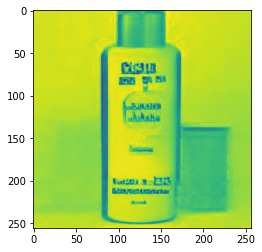

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(x.detach().numpy()[0][0])

Thus, pass code z and class y through generator G using
    
    x = G(z=z, y=y)

To get an output image.

Now test out each part of the get_activations() function from the "comparing neurons of a classifier" notebook to see which parts work for a generator.

In [4]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
    
model = G
layer_name = 'G.generator.layers.0'

for name_to_check, layer in model.named_modules():
    if name_to_check == layer_name:
        break
layer.register_forward_hook(get_activation(layer_name))

Even after register_forward_hook(), the variable  ```activation ``` will be empty until an input is run through the model using ```x = G(z=z, y=y)```





In [ ]:
activation

In [6]:
def get_activations(z, y, model, layer_name):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # preprocess = transforms.Compose([
    #     transforms.Resize(256),
    #     transforms.CenterCrop(224),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # ])
    # input_tensor = preprocess(input_image)
    # input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    # if torch.cuda.is_available():
    #     input_batch = input_batch.to('cuda')
    #     model.to('cuda')

    for name_to_check, layer in model.named_modules():
        if name_to_check == layer_name:
            break
    layer.register_forward_hook(get_activation(layer_name))
    
    # output = model(input_batch)
    x = G(z=z, y=y)

    return activation.copy()  #else will return the same actvs of model

In [7]:
layer_actvs = get_activations(z, y, G, 'G.generator.layers.0')

In [8]:
layer_actvs['G.generator.layers.0'].size()

torch.Size([1, 2048, 4, 4])

In [ ]:
get_activations(z + 0.5, y, G, 'G.generator.layers.0')